## Earthquake Clustering Tutorial
This tutorial demonstrates the earthquake clustering method by waveform similarity

The inputs:     \
    1. HypoDD output file     \
    2. dt.cc file

In [1]:
import os
import re
import copy
import pickle
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from obspy import UTCDateTime
from matplotlib.colors import LinearSegmentedColormap
from scipy.cluster.hierarchy import average, fcluster
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
def load_DD(reloc_file="hypoDD.reloc",shift_hour=0):
    """
    load results of hypoDD
    return eve_dict, df

    Parameters
    ----------
    If the time of results is not in UTC time zone, a time shift might needed.
    For example, Beijing time zone is 8 hours early than UTC time, 8 hours 
    should be deducted so as to be consistent with UTC time.
    """

    eve_dict={}
    columns = ["ID","LAT","LON","DEPTH","X","Y","Z","EX","EY","EZ",\
           "YR","MO","DY","HR","MI","SC","MAG",\
           "NCCP","NCCS","NCTP","NCTS","RCC","RCT","CID"]
    number = 0

    dataset = np.loadtxt(reloc_file)
    
    if dataset.shape[1] == 24:
        columns = ["ID","LAT","LON","DEPTH","X","Y","Z","EX","EY","EZ",\
                   "YR","MO","DY","HR","MI","SC","MAG",\
                   "NCCP","NCCS","NCTP","NCTS","RCC","RCT","CID"]
    if dataset.shape[1] == 25:
        columns = ["ID","LAT","LON","DEPTH","X","Y","Z","EX","EY","EZ",\
                   "YR","MO","DY","HR","MI","SC","MAG",\
                   "NCCP","NCCS","NCTP","NCTS","RCC","RCT","CID","DAY"]
    
    for i,data in enumerate(dataset):
        eve_id = data[0]
        eve_lat = data[1]
        eve_lon = data[2]
        eve_dep = data[3]
        eve_mag = data[16]
        eve_time = UTCDateTime(int(data[10]),int(data[11]),int(data[12]),int(data[13]),int(data[14]),0)+data[15] - shift_hour*60*60
        eve_dict[int(eve_id)]=[float(eve_lon),float(eve_lat),float(eve_dep),float(eve_mag),eve_time]

    df = pd.DataFrame(data=dataset,columns=columns)
    return eve_dict,df

def load_dtcc(dtcc="dt.cc",save_pkl=False,phases=['P','S'],minobs=4,mean_cc_threshold=0.7):
    """
    If the provided dtcc file is a pkl file, then pickle.load() will be used for loading data
    
    The programme reads in {dtcc} file and calculates average cc value for designated {phases}.
    The average cc value constrain the similarity of two events.
    
    Parameters:
        if save_pkl: a pkl file will be saved with the name {dtcc}.cluster.pkl
                     please note if dtcc file is a .pkl file, even save_pkl is True, it will not 
                     generate a new pkl file.
    """
    if dtcc[-4:] == ".pkl":                         # .pkl file load by pickle
        f = open(dtcc,'rb')
        pair_list = pickle.load(f)
        
    else:                                           # using normal processing
        pair_dict = {}
        i = 0
        f = open(dtcc,'r')
        for line in f:
            line = line.rstrip()
            if line[0] == "#":
                _,_evid1,_evid2,_ = re.split(" +",line)
                evid1 = int(_evid1); evid2 = int(_evid2)
                evid1 = min([evid1,evid2])
                evid2 = max([evid1,evid2])
            else:
                netsta,_diff,_cc,pha = re.split(" +",line)
                if evid1 not in pair_dict.keys():
                    pair_dict[evid1] = {}
                if evid2 not in pair_dict[evid1].keys():
                    pair_dict[evid1][evid2]=[]
                pair_dict[evid1][evid2].append(float(_cc))
                            
        pair_list = []
        for key1 in pair_dict.keys():
            for key2 in pair_dict[key1].keys():
                if len(pair_dict[key1][key2])<minobs:
                    continue
                mean_cc = np.mean(pair_dict[key1][key2])
                if  mean_cc < mean_cc_threshold:
                    continue
                pair_list.append([key1,key2,mean_cc])
                
        return pair_list
        
        if save_pkl:                              # generate pkl file to speed loading in future
            dtcc_pkl = dtcc+".clustering.pkl"
            with open(dtcc_pkl,'wb') as f:
                pickle.dump(pair_list,f)

    return pair_list

In [3]:
class Eqcluster():
    def __init__(self,
                 loc_file="hypoDD.reloc",
                 dtcc_file="dt.cc",
                 dtcc_save_pkl=True,
                 dtcc_phases=['P','S'],
                 dtcc_minobs=4,
                 dtcc_mean_cc_threshold=0.7):
        self.cc_threshold = dtcc_mean_cc_threshold
        self.pairs = load_dtcc(dtcc_file,
                               save_pkl=dtcc_save_pkl,
                               phases=dtcc_phases,
                               minobs = dtcc_minobs,
                               mean_cc_threshold=dtcc_mean_cc_threshold)
        self.dd_dict,_ = load_DD(loc_file)

        self.evids = np.array(list(self.dd_dict.keys())) # all event ids in the reloc file
        self.evids.sort()
        self.evids.astype(int)

        self.cc_evids = []                  # evids constrained by cross-correlation
        self.pairs_in = []
        for pair in self.pairs:
            evid1,evid2,cc = pair
            k1 = np.where(self.evids == evid1)
            k2 = np.where(self.evids == evid2)
            if len(k1[0])==1 and len(k2[0])==1:
                self.cc_evids.append(evid1)
                self.cc_evids.append(evid2)
                self.pairs_in.append(pair)                 
            if len(k1[0])>1 and len(k2[0])>1:
                raise Exception("There are duplicated event ids")
        self.cc_evids = np.array(list(set(self.cc_evids)))
        self.cc_evids.sort()
        
        # building cc_matrix
        self.cc_matrix = np.zeros((len(self.cc_evids),len(self.cc_evids)))
        for pair in self.pairs_in:
            evid1,evid2,cc = pair
            k1 = np.where(self.cc_evids == evid1)
            k2 = np.where(self.cc_evids == evid2)
            self.cc_matrix[k1[0],k2[0]] = cc
            self.cc_matrix[k2[0],k1[0]] = cc
            
        self.in_matrix_evids = self.cc_evids.copy()
        self.cluster_matrix = self.cc_matrix.copy()
            
    def clustering(self,evids=[],tolerance=0,method='average'):
        """
        Parameters:
        method: please refer to scipy.cluster.hierarchy.linkage
        tolerance: Event with inter-event cc pairs qty lower than tolerance will not be included in clustering
        """
        # build cluster matrix
        if len(evids) == 0:       
            self.input_evids = self.evids.copy()
        else:
            self.input_evids = evids
            idxs = []
            for evid in self.input_evids:
                idx = np.where(self.in_matrix_evids==evid)
                idxs.append(idx[0][0])
            self.update_cluster(idxs)
        
        # apply filter with tolerance
        print(">>> Tolerance filter applied")
        tmp = (self.cluster_matrix > 0)
        similar_qty_arr = np.sum(tmp,axis=0)
        kk = np.where(similar_qty_arr>=tolerance)
        self.update_cluster(kk[0])
        print(f"len evids is:{len(self.input_evids)}; ",\
              f"len matrix is: {len(self.in_matrix_evids)};",end=' ')
        print(f"len events not in matrix: {len(self.out_matrix_evids)}")
        
        y = pdist(self.cluster_matrix)
        self.Z = linkage(y,method=method)

    def update_cluster(self,idxs):
        """
        update cluster matrix and cluster evids
        """
        tmp = []
        for idx in idxs:
            tmp.append(self.in_matrix_evids[int(idx)])
        self.in_matrix_evids = tmp
        self.cluster_matrix = self.cluster_matrix[idxs]
        self.cluster_matrix = self.cluster_matrix[:,idxs]
        
        self.out_matrix_evids = []
        for evid in self.input_evids:
            if evid not in self.in_matrix_evids:
                 self.out_matrix_evids.append(evid)
        
        self.in_matrix_evids = np.array(self.in_matrix_evids)
        self.out_matrix_evids = np.array(self.out_matrix_evids)
          
    def dendrogram(self,xlim=[],figsize=(8,6),max_d=None,leaf_rotation=0):
        fig,ax = plt.subplots(1,figsize=figsize)
        if len(xlim)>0:
            ax.set_xlim(xlim)
        self.dn = dendrogram(self.Z,leaf_rotation=leaf_rotation)
        
        if max_d != None:
            plt.axhline(y=max_d, c='k')
            
        plt.xlabel("sample index")
        plt.ylabel("distance")
        
    def fancy_dendrogram(self,
                         truncate_mode='lastp',
                         p=12,
                         show_contracted=True,
                         max_d=None,
                         annotate_above=0,
                         leaf_rotation=0,
                         xytext=(0,-1),
                         no_plot=False):
        """
        https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
        """       
        self.dn2 = dendrogram(self.Z,
                             truncate_mode=truncate_mode,
                             p=p,
                             show_contracted=show_contracted,
                             leaf_rotation=leaf_rotation)
        
        if not no_plot:
            plt.title('Hierarchical Clustering Dendrogram (truncated)')
            plt.xlabel("sample index")
            plt.ylabel("distance")
            
        if max_d != None:
            plt.axhline(y=max_d, c='k')
            
            for i,d,c in zip(self.dn2['icoord'],self.dn2['dcoord'],self.dn2['color_list']):
                x = 0.5 * sum(i[1:3])      # "x1, x2, x3, x4", here 'x2,x3'
                y = d[1]                   # "y1, y2, y3, y4", here 'y2'
                if y > annotate_above:
                    plt.plot(x,y,'o',c=c)
                    plt.annotate("%.3g"% y, (x,y),xytext=xytext,
                                textcoords='offset points',
                                va = 'top',
                                ha = 'center')
            
    def heatmap(self,source='cluster',xlim=[],ylim=[],figsize=(5,5)):
        """
        Parameters:
        source: 'dd' to show the orignal time-sequence heatmap
                'cluster' to show the clustered heatmap
        xlim: set plt.xlim if not empty
        ylim: set plt.ylim if not empty
        """
        fig,ax = plt.subplots(1,figsize=figsize)
        if source == "dd":
            disp_matrix = self.cc_matrix
            for i in range(disp_matrix.shape[0]):
                disp_matrix[i,i] = 1
            
        elif source == "cluster":            
            disp_matrix = self.cluster_matrix.copy()
            for i in range(disp_matrix.shape[0]):
                disp_matrix[i,i] = 1
            disp_matrix = disp_matrix[self.dn['leaves']]
            disp_matrix = disp_matrix[:,self.dn['leaves']]

        if len(xlim)>0:
            plt.xlim(ylim)
        if len(ylim)>0:
            plt.ylim(ylim)
        
        colors = ["lightgrey",'lightgrey','blue','red']
        nodes = [0,self.cc_threshold,self.cc_threshold,1]
        cmap = LinearSegmentedColormap.from_list("mycmap",list(zip(nodes,colors)))
        plt.pcolormesh(disp_matrix,cmap=cmap,vmin=0,vmax=1)
        plt.gca().set_aspect('equal')
        plt.xlabel("Event No")
        plt.ylabel("Event No")
        plt.colorbar()

    def fcluster(self,max_d,criterion='distance'):
        """
        Categorize clusters and generate self.clusters_evids dict
        refer to: scipy.cluster.hierarchy.fcluster¶
        """
        self.cluster_category = fcluster(self.Z,max_d,criterion=criterion)
        print("Num of clusters: ",len(set(self.cluster_category)))
        self.clusters_evids = {}

        for cluster_id in np.unique(self.cluster_category):
            self.clusters_evids[cluster_id] = self.get_cluster_evids(cluster_id)

    def mapview(self,clusters=[],xlim=[],ylim=[],figsize=(10,5),mag_base=1):
        """
        Showing corresponding map view of earthquake locations
        Parameters:
        |   clusters: empty list for plot all, otherwide plot clusters in the list
        |       xlim: if not empty, set plt.xlim
        |       ylim: if not empty, set plt.ylim
        |   mag_base: parameters control the magnitude size
        """
        fig,ax = plt.subplots(1,figsize=figsize)

        lons = []
        lats = []
        mags = []
               
        for evid in self.in_matrix_evids:
            lons.append(self.dd_dict[evid][0])
            lats.append(self.dd_dict[evid][1])
            mags.append(self.dd_dict[evid][3])
        lons = np.array(lons)
        lats = np.array(lats)
        mags = np.array(mags)
        cmap = matplotlib.cm.get_cmap('tab20',int(np.max(self.cluster_category)))
        
        if len(clusters)==0:
            plt.scatter(lons,lats,
                        c=self.cluster_category,
                        s=mags-np.min(mags)+mag_base,
                        cmap=cmap,vmin=1,
                        vmax=int(np.max(self.cluster_category))+1)
        else:
            kks = np.array([],dtype=int)
            for cid in clusters:
                kk = np.where(self.cluster_category==cid)
                kks = np.concatenate((kks,kk[0]))
            plt.scatter(lons[kks],lats[kks],
                        c=self.cluster_category[kks],
                        s=mags[kks]-np.min(mags)+mag_base,
                        cmap=cmap,vmin=1,
                        vmax=int(np.max(self.cluster_category))+1)
                
        if len(xlim)>0:
            plt.xlim(xlim)
        if len(ylim)>0:
            plt.ylim(ylim)
        ax.set_aspect('equal')
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        cb = plt.colorbar()
        cb.set_label("Cluster")
        
    def get_cluster_evids(self,cluster_id):
        kk = np.where(self.cluster_category==cluster_id)
        sel_cluster_evids = self.in_matrix_evids[kk[0]]   
        
        return sel_cluster_evids
    
    def __repr__(self):
        str1 = f"Eqcluster object with {len(self.evids)} events in hypoDD relocation file\n"
        str2 = f"{len(self.evids)} events constrained by dt.cc file"
        return str1+str2
    
    def copy(self):
        return copy.deepcopy(self)

In [4]:
demo = Eqcluster("hypoDD.reloc",dtcc_file = "dt.cc")

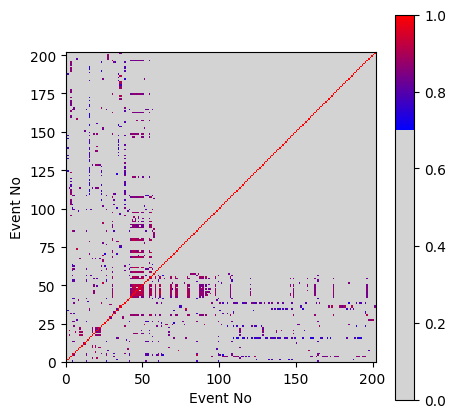

In [5]:
# A general overview of the cross-correlation matrix
# Event sequence is ordered by time
demo.heatmap(source='dd')

In [6]:
demo.clustering(tolerance=5,method='complete')

>>> Tolerance filter applied
len evids is:990;  len matrix is: 71; len events not in matrix: 919


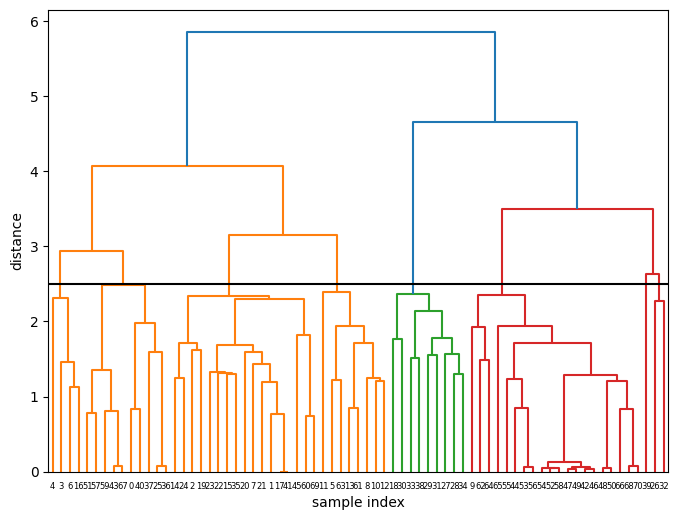

In [7]:
demo.dendrogram(max_d=2.5);

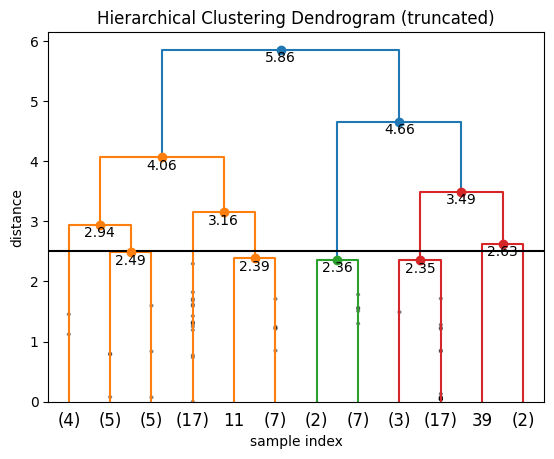

In [8]:
demo.fancy_dendrogram(p=12,max_d=2.5)

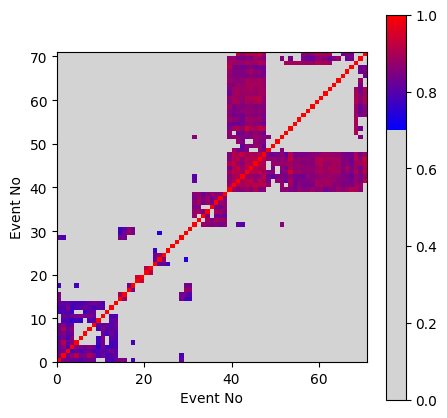

In [9]:
demo.heatmap()

## Map-view of clustered events

In [10]:
# The first step is to divide clusters
# refer to scipy.cluster.hierarchy.fcluster¶
demo.fcluster(max_d=2.5,criterion='distance')

Num of clusters:  8


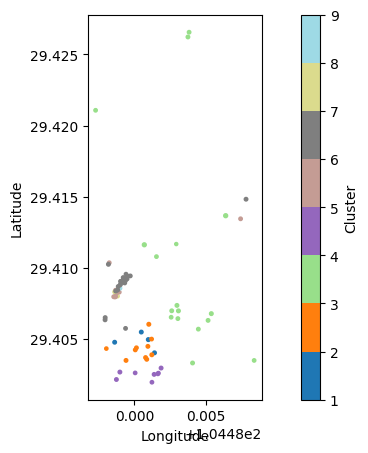

In [11]:
# An overview of all clusters, clusters=[] means display all
# Parameter mag_base controls the magnitude size of event markers
demo.mapview(clusters=[],mag_base = 5)

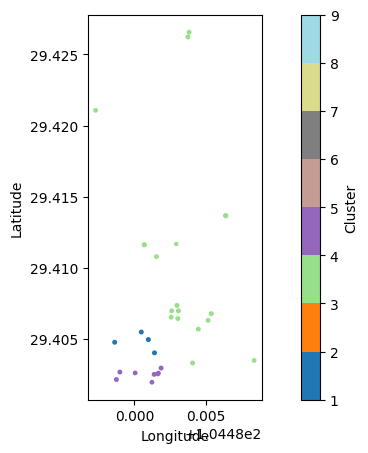

In [12]:
# To plot cluster 1,3,and 4, put them in the parameter clusters
demo.mapview(clusters=[1,3,4],mag_base = 5)